In [1]:
# Autoreload extension
if 'autoreload' not in get_ipython().extension_manager.loaded:
    %load_ext autoreload
%autoreload 2

In [2]:
import seqexplainer

Global seed set to 13


GPU is available: True
Number of GPUs: 1
Current GPU: 0
GPUs: Quadro RTX 5000


# DeepSTARR

## With a Peter Koo model

### Get the model and data

In [3]:
import os
import torch
import evoaug
from evoaug import evoaug, augment
from evoaug_analysis import utils, model_zoo

In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
%%bash
cd ../../models/evoaug
wget https://zenodo.org/record/7277777/files/attr_analysis.zip
unzip attr_analysis.zip

In [ ]:
%%bash
mkdir ../../data/DeepSTARR
cd ../../data/DeepSTARR
wget https://zenodo.org/record/7265991/files/DeepSTARR_data.h5

--2023-01-25 21:56:31--  https://zenodo.org/record/7265991/files/DeepSTARR_data.h5
Resolving zenodo.org (zenodo.org)... 188.185.124.72
Connecting to zenodo.org (zenodo.org)|188.185.124.72|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 294581428 (281M) [application/octet-stream]
Saving to: ‘DeepSTARR_data.h5’

     0K .......... .......... .......... .......... ..........  0%  314K 15m17s
    50K .......... .......... .......... .......... ..........  0%  313K 15m18s
   100K .......... .......... .......... .......... ..........  0%  189M 10m13s
   150K .......... .......... .......... .......... ..........  0%  313K 11m29s
   200K .......... .......... .......... .......... ..........  0%  313K 12m14s
   250K .......... .......... .......... .......... ..........  0%  313K 12m45s
   300K .......... .......... .......... .......... ..........  0%  313K 13m6s
   350K .......... .......... .......... .......... ..........  0%  313K 13m23s
   400K .......... ....

In [5]:
data_module = utils.H5DataModule("../../data/DeepSTARR/DeepSTARR_data.h5", batch_size=100, lower_case=False, transpose=False)

In [6]:
output_dir = "../../models/evoaug/attr_analysis"
ckpt_path = os.path.join(output_dir, 'DeepSTARR_baseline_1.ckpt')

deepstarr = model_zoo.DeepSTARR(2)
loss = torch.nn.MSELoss()
optimizer_dict = utils.configure_optimizer(deepstarr, lr=0.001, weight_decay=1e-6, decay_factor=0.1, patience=5, monitor='val_loss')
standard_cnn = evoaug.RobustModel(deepstarr, 
                                 criterion=loss, 
                                 optimizer=optimizer_dict, 
                                 augment_list=[])

# load model weights
standard_cnn = evoaug.load_model_from_checkpoint(standard_cnn, ckpt_path)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torch/nn/modules/lazy.py:178: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [7]:
# evaluate best model
#pred = utils.get_predictions(standard_cnn, data_module.x_test, batch_size=100)
#results = utils.evaluate_model(data_module.y_test, pred, task='regression')   # task is 'binary' or 'regression'
#print('Pearson r Dev: %.4f'%(results[1][0]))
#print('Pearson r HK : %.4f'%(results[1][1]))

In [8]:
from captum.attr import GradientShap
import logomaker
import matplotlib.pyplot as plt
import tfomics
import h5py
import numpy as np

In [9]:
dataset = h5py.File("../../data/DeepSTARR/DeepSTARR_data.h5", 'r')

In [10]:
x_test = np.array(dataset['X_test']).astype(np.float32)
y_test = np.array(dataset['Y_test']).astype(np.float32)

In [ ]:
N,A,L = x_test.shape
sort = [
        31226,
        22612, 
        96,
        162,
        21106,
        2019,
        21283,
        20755,
        7811,
        26878,
        513,
        3346,
        26579,
        23930,
        ]
num_plot = len(sort)
X = x_test[sort]

In [12]:
standard_cnn.eval()

RobustModel(
  (model): DeepSTARR(
    (activation): ReLU()
    (dropout4): Dropout(p=0.4, inplace=False)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (batchnorm1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (activation1): ReLU()
    (maxpool1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm2): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool2): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm3): BatchNorm1d(60, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (batchnorm4): BatchNorm1d(120, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (maxpool4): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc5): Linear(in_features=0, out_features=256, bias=True)


### With Peter Koo code

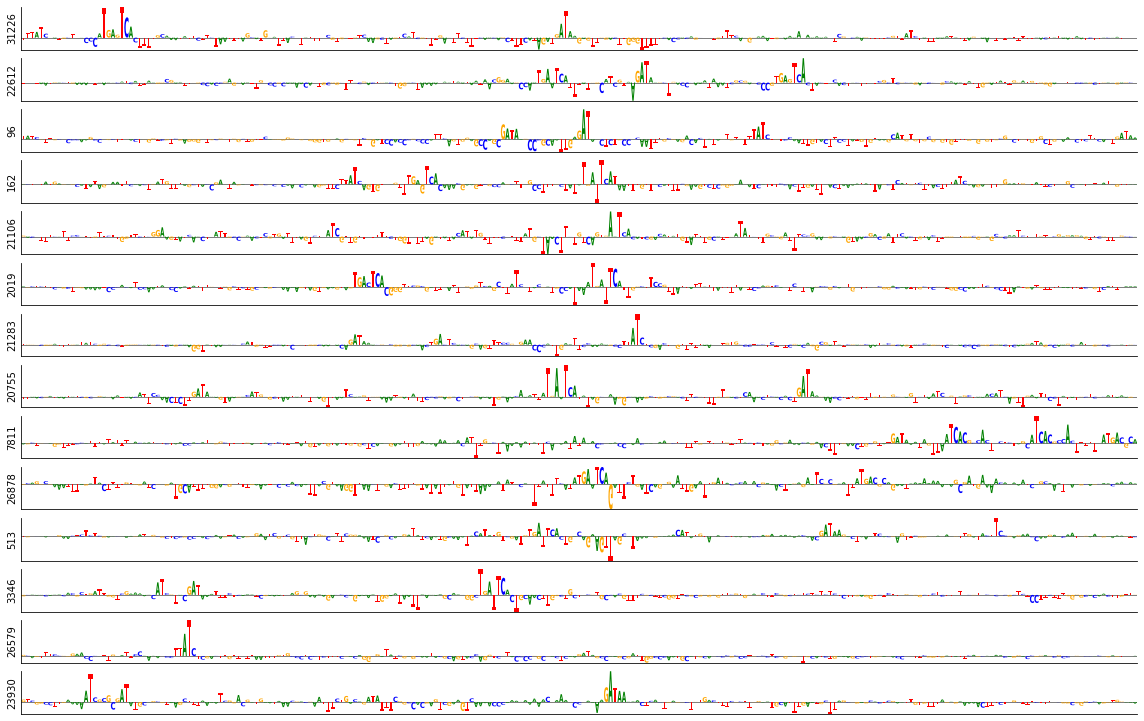

In [13]:
fig = plt.figure(figsize=(20,13))
for i,x in enumerate(X):
    # process sequences so that they are right shape (based on insertions)
    x = np.expand_dims(x, axis=0)
    x_tensor = torch.tensor(x, requires_grad=True, dtype=torch.float32)

    # get predictions of models
    output = standard_cnn(x_tensor)
    prediction_score, pred_label_idx = torch.topk(output, 1)
    pred_label_idx.squeeze_()

    # random background
    num_background = 1000
    null_index = np.random.randint(0,3, size=(num_background,L))
    x_null = np.zeros((num_background,A,L))
    for n in range(num_background):
        for l in range(L):
           x_null[n,null_index[n,l],l] = 1.0
    x_null_tensor = torch.tensor(x_null, requires_grad=True, dtype=torch.float32)

    # calculate gradient shap
    gradient_shap = GradientShap(standard_cnn)
    grad = gradient_shap.attribute(x_tensor,
                                  n_samples=100,
                                  stdevs=0.1,
                                  baselines=x_null_tensor,
                                  target=pred_label_idx)
    grad = grad.data.cpu().numpy()

    # process gradients with gradient correction (Majdandzic et al. 2022)
    grad -= np.mean(grad, axis=1, keepdims=True)

    # plot sequence logo of grad times input
    ax = plt.subplot(num_plot,1,i+1)
    saliency_df = tfomics.impress.grad_times_input_to_df(x.transpose([0,2,1]), grad.transpose([0,2,1]))
    tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    plt.ylabel(sort[i])

##

### With SeqExplainer

In [32]:
x_tensor = torch.tensor(X, requires_grad=True, dtype=torch.float32)

In [66]:
explains = seqexplainer.attribute(
    standard_cnn,
    x_tensor,
    method="DeepLiftShap",
    target=0,
    reference_type="zero",
#    n_samples=100,
#    stdevs=0.1
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  module


RuntimeError: A Module ReLU() was detected that does not contain some of the input/output attributes that are required for DeepLift computations. This can occur, for example, if your module is being used more than once in the network.Please, ensure that module is being used only once in the network.

In [ ]:
explains = explains.detach().cpu().numpy()
explains -= np.mean(explains, axis=1, keepdims=True)
explains = explains*X

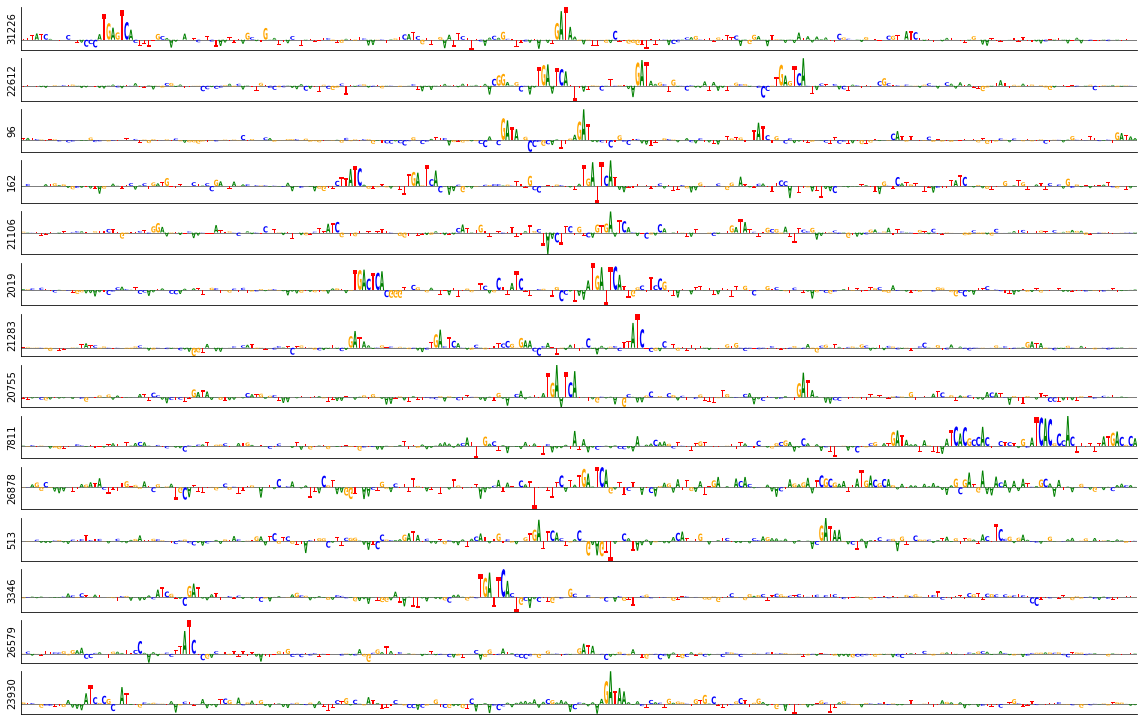

In [ ]:
fig = plt.figure(figsize=(20,13))
for i in range(num_plot):
    ax = plt.subplot(num_plot, 1, i+1)
    saliency_df = pd.DataFrame(explains[i].transpose([1,0]), columns=["A","C","G","T"])
    saliency_df.index.name = "pos"
    tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    plt.ylabel(sort[i])

### With a EUGenE model

In [55]:
import eugene as eu

In [57]:
eugene_cnn = eu.models.DeepSTARR.load_from_checkpoint("../../models/DeepSTARR.ckpt")

In [62]:
explains = seqexplainer.attribute(
    eugene_cnn,
    x_tensor,
    method="DeepLiftShap",
    target=0,
    reference_type="zero",
#    n_samples=100,
#    stdevs=0.1
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  module
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torch/nn/functional.py:651: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool1d in a future release.
  warnings.warn("Note t

In [63]:
explains = explains.detach().cpu().numpy()
explains -= np.mean(explains, axis=1, keepdims=True)
explains = explains*X

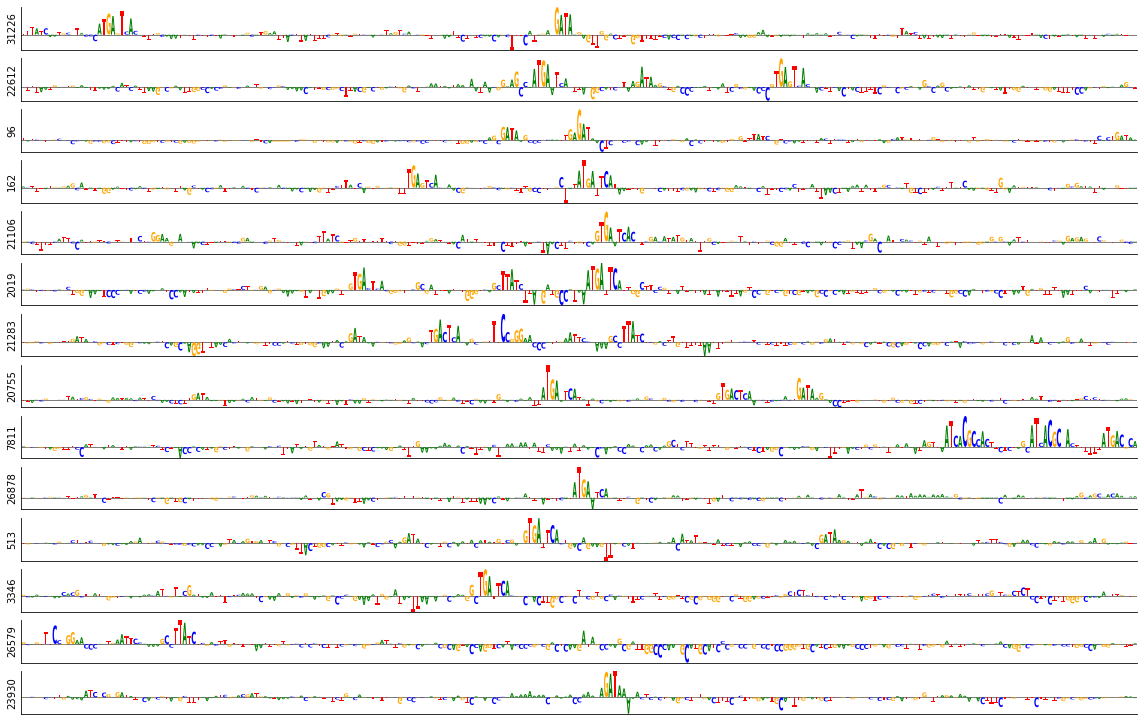

In [64]:
fig = plt.figure(figsize=(20,13))
for i in range(num_plot):
    ax = plt.subplot(num_plot, 1, i+1)
    saliency_df = pd.DataFrame(explains[i].transpose([1,0]), columns=["A","C","G","T"])
    saliency_df.index.name = "pos"
    tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    plt.ylabel(sort[i])

### With a generic PyTorch model: TODO

In [ ]:
import pytorch_lightning as pl

# PlantPromoter

## With EUGENe

### Get model and data

In [3]:
import torch
import numpy as np
import pandas as pd
import tfomics
import matplotlib.pyplot as plt
import eugene as eu

In [4]:
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

In [5]:
model = eu.models.Hybrid.load_from_checkpoint("/cellar/users/aklie/projects/SeqExplainer/models/jores21/PlantPromoter.ckpt")

In [6]:
sdata = eu.datasets.jores21(dataset="leaf")

Dataset jores21 CNN_test_leaf.tsv has already been downloaded.
Dataset jores21 CNN_train_leaf.tsv has already been downloaded.


In [7]:
sdata_test = sdata[sdata["set"] == "test"]
eu.pp.ohe_seqs_sdata(sdata_test)

One-hot encoding sequences:   0%|          | 0/7154 [00:00<?, ?it/s]

SeqData object modified:
	ohe_seqs: None -> 7154 ohe_seqs added


In [8]:
del sdata

In [9]:
# Randomly select 10 sequences with random seed
np.random.seed(0)
sort = np.random.choice(sdata_test.n_obs, 10)
X = sdata_test.ohe_seqs[sort]

In [10]:
# Turn into a tensor
x_tensor = torch.tensor(X, requires_grad=True, dtype=torch.float32)

In [11]:
x_tensor.shape

torch.Size([10, 4, 170])

In [12]:
explains = seqexplainer.attribute(
    model,
    x_tensor,
    method="NaiveISM",
    target=0,
    batch_size=10,
#    reference_type="profile",
#    n_samples=100,
#    stdevs=0.1
)

cuda:0


In [14]:
explains = explains.detach().cpu().numpy()
explains -= np.mean(explains, axis=1, keepdims=True)
explains = explains*X

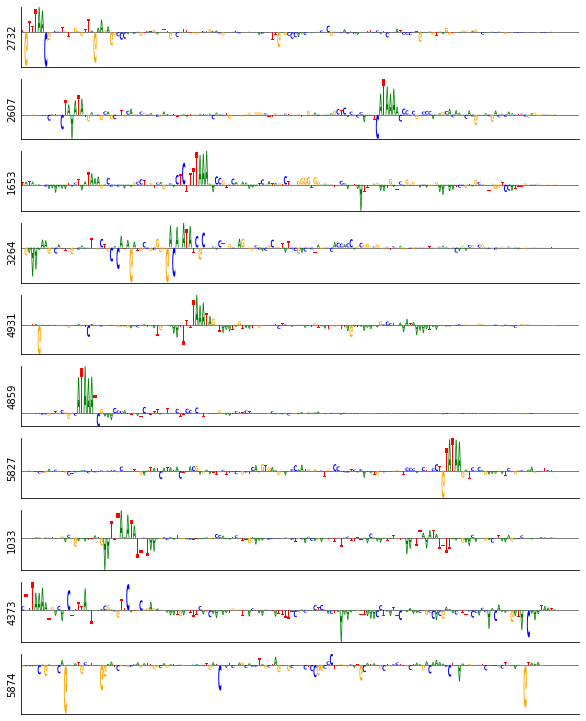

In [15]:
num_plot = 10
fig = plt.figure(figsize=(num_plot,13))
for i in range(num_plot):
    ax = plt.subplot(num_plot, 1, i+1)
    saliency_df = pd.DataFrame(explains[i].transpose([1,0]), columns=["A","C","G","T"])
    saliency_df.index.name = "pos"
    tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(20,1))
    plt.ylabel(sort[i])

# CTCF CNN

In [43]:
import os
import eugene as eu

In [41]:
from eugene.dataload.datamodules._H5DataModule import H5DataModule
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

In [42]:
filepath = os.path.join(eu.settings.dataset_dir, "lee22", "CTCF_200.h5")
data_module = H5DataModule(filepath, batch_size=128, lower_case=True, transpose=False)

In [45]:
loader = data_module.test_dataloader()

In [46]:
dataset = loader.dataset

In [47]:
X_np = dataset.seqs
y_np = dataset.targets

In [48]:
# Randomly select 10 sequences with random seed
np.random.seed(0)
sort = np.random.choice(X_np.shape[0], 10)
X = X_np[sort]
y = y_np[sort]

In [50]:
x_tensor = torch.tensor(X, requires_grad=True, dtype=torch.float32)

In [58]:
import torch
import torch.nn as nn
import eugene.models.base._blocks as blocks
import eugene.models.base._towers as towers
import eugene.models.base._layers as layers
from eugene.models import SequenceModel
class customConv(SequenceModel):
    
    def __init__(
        self,
        input_len: int,
        output_dim: int,
        strand: str = "ss",
        task: str = "binary_classification",
        aggr: str = None,
        loss_fxn: str = "bce",
        **kwargs
    ):
        super().__init__(
            input_len, 
            output_dim, 
            strand=strand, 
            task=task, 
            aggr=aggr, 
            loss_fxn=loss_fxn, 
            **kwargs
        )
        self.model = nn.Sequential()
        self.model.add_module(
            "conv_tower",
            towers.Tower(
                input_size=(4, input_len),
                block=blocks.Conv1DBlock,
                repeats=3,
                static_block_args=dict(input_len=200, dropout_rate=0.2, order="conv-norm-act-dropout-pool"),
                dynamic_block_args=dict(input_channels=[4, 64, 96], output_channels=[64, 96, 128], conv_kernel=[7, 5, 5], pool_kernel=[4, 4, 2])
            )
        )
        self.model.add_module("flatten_layer", layers.Flatten())
        self.model.add_module(
            "dense_block",
            blocks.DenseBlock(
                input_dim=np.product(self.model.conv_tower.output_size), 
                output_dim=output_dim, 
                hidden_dims=[256],
                batchnorm=True,
                batchnorm_first=True, 
                dropout_rates=0.5,
            )
        )
            
    def forward(self, x, x_rev_comp=None):
        return self.model(x)

In [59]:
ctcf_cnn = customConv.load_from_checkpoint("/cellar/users/aklie/projects/SeqExplainer/models/lee22/CTCF.ckpt")

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [60]:
ctcf_cnn.eval()

customConv(
  (train_metric): AUROC()
  (val_metric): AUROC()
  (test_metric): AUROC()
  (model): Sequential(
    (conv_tower): Tower(
      (blocks): Sequential(
        (conv1dblock_0): Conv1DBlock(
          (layers): Sequential(
            (conv): Conv1d(4, 64, kernel_size=(7,), stride=(1,), padding=valid)
            (norm): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
            (dropout): Dropout(p=0.2, inplace=False)
            (pool): MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False)
          )
        )
        (conv1dblock_1): Conv1DBlock(
          (layers): Sequential(
            (conv): Conv1d(64, 96, kernel_size=(5,), stride=(1,), padding=valid)
            (norm): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act): ReLU()
            (dropout): Dropout(p=0.2, inplace=False)
            (pool): MaxPool1d(kernel_size=4, stride=4, paddin

In [ ]:
# Turn into a tensor
x_tensor = torch.tensor(X, requires_grad=True, dtype=torch.float32)

In [63]:
x_tensor.shape

torch.Size([10, 4, 200])

In [64]:
explains = seqexplainer.attribute(
    ctcf_cnn,
    x_tensor,
    method="DeepLiftShap",
    target=0,
    reference_type="zero",
#    n_samples=100,
#    stdevs=0.1
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=4, stride=4, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  module
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be use

In [65]:
explains = explains.detach().cpu().numpy()
explains -= np.mean(explains, axis=1, keepdims=True)
explains = explains*X

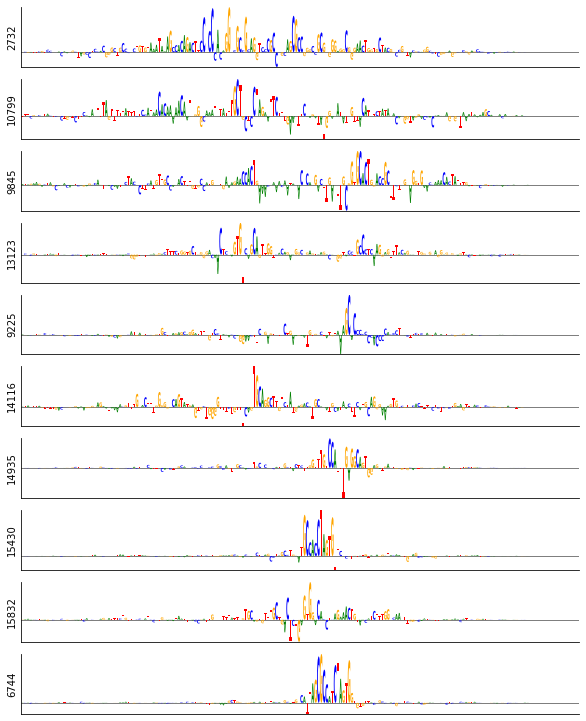

In [66]:
num_plot = 10
fig = plt.figure(figsize=(num_plot,13))
for i in range(num_plot):
    ax = plt.subplot(num_plot, 1, i+1)
    saliency_df = pd.DataFrame(explains[i].transpose([1,0]), columns=["A","C","G","T"])
    saliency_df.index.name = "pos"
    tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(num_plot,1))
    plt.ylabel(sort[i])

# Basset

In [6]:
import os
import eugene as eu

In [7]:
from eugene.dataload.datamodules._H5DataModule import H5DataModule
eu.settings.dataset_dir = "/cellar/users/aklie/data/eugene"

In [8]:
filepath = os.path.join(eu.settings.dataset_dir, "lee22", "Basset_data.h5")
data_module = H5DataModule(filepath, batch_size=128, lower_case=False, transpose=False)

In [44]:
loader = data_module.test_dataloader()

In [18]:
dataset = loader.dataset

In [33]:
X_np = dataset.seqs
y_np = dataset.targets

In [34]:
# Randomly select 10 sequences with random seed
np.random.seed(0)
sort = np.random.choice(X_np.shape[0], 10)
X = X_np[sort]
y = y_np[sort]

In [35]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 1., 1., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [23]:
x_tensor = torch.tensor(X, requires_grad=True, dtype=torch.float32)

In [25]:
basset = eu.models.Basset.load_from_checkpoint("/cellar/users/aklie/projects/SeqExplainer/models/kelley16/Basset.ckpt")

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/torchmetrics/utilities/prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [26]:
# Turn into a tensor
x_tensor = torch.tensor(X, requires_grad=True, dtype=torch.float32)

In [37]:
basset(x_tensor.to(basset.device)).shape

torch.Size([10, 164])

In [38]:
explains = seqexplainer.attribute(
    basset,
    x_tensor,
    method="DeepLiftShap",
    target=163,
    reference_type="zero",
#    n_samples=100,
#    stdevs=0.1
)

/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:339: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  after the attribution is finished"""
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  module
/cellar/users/aklie/opt/miniconda3/envs/eugene_dev/lib/python3.7/site-packages/captum/attr/_core/deep_lift.py:471: UserWarning: An invalid module MaxPool1d(kernel_size=4, stride=1, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be use

In [39]:
explains = explains.detach().cpu().numpy()
explains -= np.mean(explains, axis=1, keepdims=True)
explains = explains*X

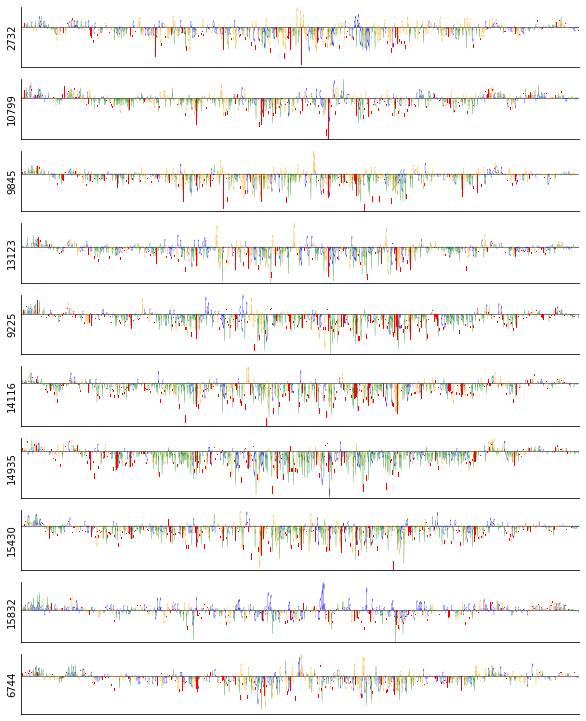

In [40]:
num_plot = 10
fig = plt.figure(figsize=(num_plot,13))
for i in range(num_plot):
    ax = plt.subplot(num_plot, 1, i+1)
    saliency_df = pd.DataFrame(explains[i].transpose([1,0]), columns=["A","C","G","T"])
    saliency_df.index.name = "pos"
    tfomics.impress.plot_attribution_map(saliency_df, ax, figsize=(num_plot,1))
    plt.ylabel(sort[i])

---

# Scratch